# Transcript Set Analysis

Compare a few transcript sets to answer the following questions:

1. How many genes have multiple TSS, and how far apart are they?
2. For genes with multiple TSS, are more than one accessible in the dataset?
3. ???

In [42]:
library(GenomicRanges)
library(rtracklayer)
library(ggplot2)

## Load GENCODE Basic

In [4]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))

Warning message in readGFF(filepath, version = version, filter = filter):
“connection is not positioned at the start of the file, rewinding it”


In [90]:
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")

In [91]:
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 3)
length(gencode.basic.tx.hg38)

GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [219]:
gencode.basic.tss.hg38 = unique(resize(gencode.basic.tx.hg38, width = 1, fix="start"))
head(gencode.basic.tss.hg38, 3)

GRanges object with 3 ranges and 21 metadata columns:
      seqnames    ranges strand |   source       type     score     phase
         <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1     65419      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1     69055      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1    451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  p

In [220]:
quantile(table(gencode.basic.tss.hg38$gene_id), c(0,.25,.5,.75,1))

  0%  25%  50%  75% 100% 
   1    1    2    3   33 

In [231]:
tss_ranges = aggregate(start(gencode.basic.tss.hg38), by=list(gencode.basic.tss.hg38$gene_name), range)
colnames(tss_ranges) = c("gene_name", "range")
tss_ranges$diff = abs(tss_ranges$range[,1]-tss_ranges$range[,2])

rownames(tss_ranges) = tss_ranges$gene_name

dim(tss_ranges)
head(tss_ranges)

[1] 19894     3

,gene_name,range,diff
,<chr>,"<int[,2]>",<int>
A1BG,A1BG,"58353492, 58353492",0
A1CF,A1CF,"50859985, 50885675",25690
A2M,A2M,"9116157, 9116157",0
A2ML1,A2ML1,"8822621, 8845004",22383
A3GALT2,A3GALT2,"33321098, 33321098",0
A4GALT,A4GALT,"42694986, 42720870",25884


In [232]:
# a few genes are on multiple chrs, remove them
chr_counts = table(unique(data.frame(gencode.basic.tss.hg38)[,c("seqnames", "gene_name")])$gene_name)
sum(chr_counts>1)

tss_ranges = tss_ranges[tss_ranges$gene_name %in% names(chr_counts[chr_counts==1]), ]
dim(tss_ranges)

[1] 18

[1] 19876     3

In [233]:
head(gene_chr)

,seqnames,gene_name
,<fct>,<chr>
OR4F5,chr1,OR4F5
OR4F29,chr1,OR4F29
OR4F16,chr1,OR4F16
SAMD11,chr1,SAMD11
NOC2L,chr1,NOC2L
KLHL17,chr1,KLHL17


In [234]:
# assign chromosome to remaining genes
gene_chr = unique(data.frame(gencode.basic.tss.hg38)[,c("seqnames", "gene_name")])
gene_chr = gene_chr[gene_chr$gene_name %in% names(chr_counts[chr_counts==1]), ]
rownames(gene_chr) = gene_chr$gene_name

tss_ranges$chr = gene_chr[tss_ranges$gene_name, "seqnames"]
head(tss_ranges)

,gene_name,range,diff,chr
,<chr>,"<int[,2]>",<int>,<fct>
A1BG,A1BG,"58353492, 58353492",0,chr19
A1CF,A1CF,"50859985, 50885675",25690,chr10
A2M,A2M,"9116157, 9116157",0,chr12
A2ML1,A2ML1,"8822621, 8845004",22383,chr12
A3GALT2,A3GALT2,"33321098, 33321098",0,chr1
A4GALT,A4GALT,"42694986, 42720870",25884,chr22


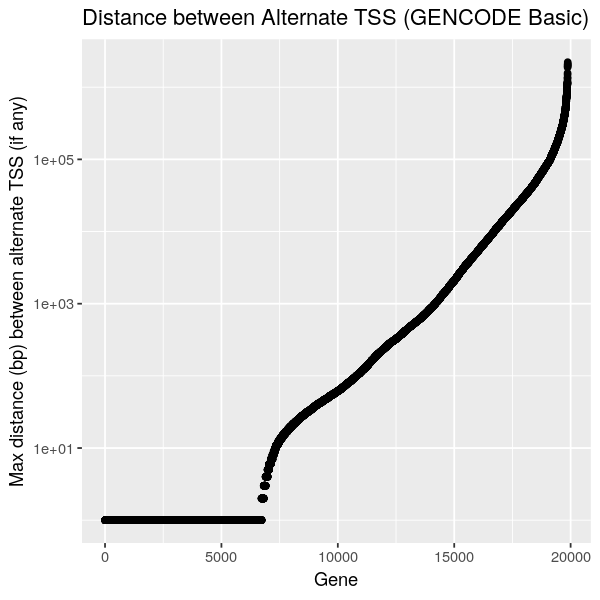

In [235]:
options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(data.frame(tss_ranges[order(tss_ranges$diff),],
                 x=seq(dim(tss_ranges)[1])),
       aes(x=x, y=1+diff)) +
ggtitle("Distance between Alternate TSS (GENCODE Basic)") +
xlab("Gene") + 
ylab("Max distance (bp) between alternate TSS (if any)") +
scale_y_continuous(trans='log10') +
geom_point()

In [236]:
# how many other genes between alternate TSSes of a gene?
range_gr = GRanges(data.frame(chr=tss_ranges$chr, 
                   start=apply(tss_ranges$range, 1, min),
                   end=apply(tss_ranges$range, 1, max)))
overlaps = findOverlaps(range_gr, gencode.basic.tss.hg38)

intersect_gene_df = data.frame(range_gene_name = tss_ranges[queryHits(overlaps), "gene_name"], 
           tss_gene_name = gencode.basic.tss.hg38[subjectHits(overlaps)]$gene_name)
intersect_gene_df = unique(intersect_gene_df[intersect_gene_df$range_gene_name!=intersect_gene_df$tss_gene_name, ])
head(intersect_gene_df)

,range_gene_name,tss_gene_name
,<fct>,<fct>
31,AAGAB,IQCH
68,AATK,PVALEF
103,ABCB1,RUNDC3B
135,ABCB9,OGFOD2
142,ABCB9,ARL6IP4
157,ABCC11,LONP2


In [242]:
tss_ranges$other_genes_in_range = as.vector(table(intersect_gene_df$range_gene_name)[tss_ranges$gene_name])
head(tss_ranges[rev(order(tss_ranges$other_genes_in_range)),])

,gene_name,range,diff,chr,other_genes_in_range
,<chr>,"<int[,2]>",<int>,<fct>,<int>
HBG2,HBG2,"5254741, 5505605",250864,chr11,11
MMP26,MMP26,"4767270, 4988194",220924,chr11,10
HBE1,HBE1,"5269945, 5505652",235707,chr11,10
TRIM5,TRIM5,"5685042, 5872358",187316,chr11,8
PRH1,PRH1,"10884253, 11047190",162937,chr12,7
RMI2,RMI2,"11249649, 11345470",95821,chr16,5


In [243]:
sum(tss_ranges$other_genes_in_range>0)

[1] 911

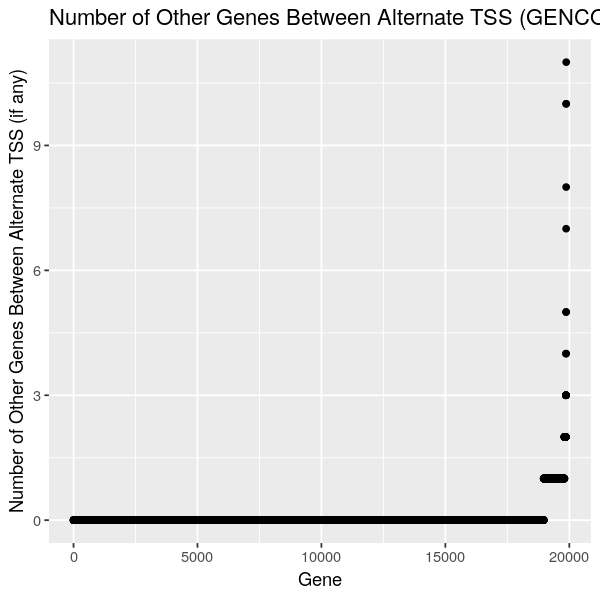

In [244]:
options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(data.frame(tss_ranges[order(tss_ranges$other_genes_in_range),],
                 x=seq(dim(tss_ranges)[1])),
       aes(x=x, y=other_genes_in_range)) +
ggtitle("Number of Other Genes Between Alternate TSS (GENCODE Basic)") +
xlab("Gene") + 
ylab("Number of Other Genes Between Alternate TSS (if any)") +
geom_point()

## Load ArchR Gene Set

ArchR uses gene set from UCSC txdb knownGene.

In [13]:
load("../../../resources/ArchRGene/geneAnnoHg38.rda")

In [16]:
ucsc.knownGene.hg38 = geneAnnoHg38$genes

In [180]:
ucsc.knownGene.tss.hg38 = resize(ucsc.knownGene.hg38, width=1, fix = "start")

In [182]:
ucsc.knownGene.tss.hg38

GRanges object with 25017 ranges and 2 metadata columns:
          seqnames    ranges strand |     gene_id       symbol
             <Rle> <IRanges>  <Rle> | <character>  <character>
      [1]     chr1     69091      + |       79501        OR4F5
      [2]     chr1    140339      - |      729737    LOC729737
      [3]     chr1    629010      - |   101928626 LOC101928626
      [4]     chr1    632413      - |   102465432         <NA>
      [5]     chr1    817371      + |      400728       FAM87B
      ...      ...       ...    ... .         ...          ...
  [25013]     chrY  21594666      - |       83868       TTTY13
  [25014]     chrY  21918067      - |      378949       RBMY1D
  [25015]     chrY  22298876      - |       83863        TTTY5
  [25016]     chrY  23199094      - |        1617         DAZ1
  [25017]     chrY  23219447      + |       57055         DAZ2
  -------
  seqinfo: 24 sequences from hg38 genome

In [183]:
# all have one transcript
max(table(ucsc.knownGene.tss.hg38$gene_id))

[1] 1

## Overlap Between the 2 sets

In [245]:
length(intersect(ucsc.knownGene.tss.hg38$symbol, gencode.basic.tss.hg38$gene_name))

[1] 18619

In [246]:
# seem to be mostly lncRNA and miRNA etc
length(setdiff(ucsc.knownGene.tss.hg38$symbol, gencode.basic.tss.hg38$gene_name))
sample(setdiff(ucsc.knownGene.tss.hg38$symbol, gencode.basic.tss.hg38$gene_name), 5)

[1] 6343

[1] "LINC01297"    "HNF4A-AS1"    "MIR4772"      "LOC101927136" "LINC02274"

In [247]:
# seems like there is a naming mismatch for these genes but they are present + few novel transcripts
length(setdiff(gencode.basic.tss.hg38$gene_name, ucsc.knownGene.tss.hg38$symbol))
sample(setdiff(gencode.basic.tss.hg38$gene_name, ucsc.knownGene.tss.hg38$symbol), 5)

[1] 1275

[1] "H3-3A"      "AC026464.6" "AL353579.1" "H2BC21"     "AC084121.6"

In [248]:
# how many have nearby TSSes (this will also include those with name mismatches)
ucsc_genes_intersect_tss = ucsc.knownGene.tss.hg38[unique(queryHits(findOverlaps(ucsc.knownGene.tss.hg38+1000, gencode.basic.tss.hg38+1000)))]$symbol
length(ucsc_genes_intersect_tss)

[1] 17966

In [249]:
# UCSC genes TSS of which don't intersect one from GENCODE
ucsc_genes_not_intersect_tss = setdiff(ucsc.knownGene.tss.hg38$symbol, ucsc_genes_intersect_tss)
length(ucsc_genes_not_intersect_tss)
sample(ucsc_genes_not_intersect_tss, 5)

[1] 7009

[1] "LOC101929705" "INTS12"       "MIR3130-2"    "MIR6806"      "LOC101929352"

In [250]:
# genes present in GENCODE which don't overlap
length(ucsc_genes_not_intersect_tss[ucsc_genes_not_intersect_tss %in% gencode.basic.tss.hg38$gene_name])
sample(ucsc_genes_not_intersect_tss[ucsc_genes_not_intersect_tss %in% gencode.basic.tss.hg38$gene_name], 5)

[1] 1280

[1] "ZNF529" "SYT9"   "BEGAIN" "SASH1"  "ELMO2"

In [262]:
GENE = "NUTM2B"
ucsc.knownGene.tss.hg38[ucsc.knownGene.tss.hg38$symbol%in% c(GENE)]
gencode.basic.tss.hg38[gencode.basic.tss.hg38$gene_name%in% c(GENE)]

GRanges object with 1 range and 2 metadata columns:
      seqnames    ranges strand |     gene_id      symbol
         <Rle> <IRanges>  <Rle> | <character> <character>
  [1]    chr10  79703227      + |      729262      NUTM2B
  -------
  seqinfo: 24 sequences from hg38 genome

GRanges object with 2 ranges and 21 metadata columns:
      seqnames    ranges strand |   source       type     score     phase
         <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]    chr10  79703227      + |  ENSEMBL transcript      <NA>      <NA>
  [2]    chr10  79703279      + |   HAVANA transcript      <NA>      <NA>
                 gene_id      gene_type   gene_name       level     hgnc_id
             <character>    <character> <character> <character> <character>
  [1] ENSG00000188199.10 protein_coding      NUTM2B           3  HGNC:23445
  [2] ENSG00000188199.10 protein_coding      NUTM2B           2  HGNC:23445
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000018572.3 ENST00000429828.5  protein_coding      NUTM2B-203
  [2] OTTHUMG00000018572.3 ENST00000372321.5  protein_coding      NUTM2B-202
      transcript_support_level        